# Challenge solved by Alexei Bushuev "alexeib.2020@gmail.com"

In [1]:
!pip install requests
!pip install pandas
!pip install mplfinance

### Endpoint:
#### https://api.worldtradingdata.com/api/v1/stock_search?limit=50&page=1&api_token=[token]&search_term=new%20york
### depricated and returned error message:

```json
{
	"0": "#################################################################################################################################",
	"1": "#",
	"2": "# IMPORTANT - PLEASE UPDATE YOUR API ENDPOINT",
	"3": "#",
	"4": "#",
	"5": "# This API endpoint is deprecated and now has been shut down. ",
	"6": "# To keep using our free stock market API, please update your integration to use the new marketstack API endpoint.#",
	"7": "# You will find more information by visiting https://marketstack.com.",
	"8": "#",
	"9": "#################################################################################################################################"
}
```
### Will use endpoint:
#### http://api.marketstack.com/v1/eod?access_key=d8f2a2b437c3c6e1a7c6ebdf71b83455&symbols=AAPL

In [2]:
# define credentials
credentials = 'access_key=d8f2a2b437c3c6e1a7c6ebdf71b83455'
symbols = 'AAPL'
limit = 50

## Solution

In [3]:
import requests
from dataclasses import dataclass
from typing import Any, Iterable

@dataclass
class Task:
    credentials:str
    symbols:str
    page:int = 1

@dataclass
class TaskResult:
    task:Task
    data:Any
    next_tasks: Iterable[Task]

def handler(task:Task) -> TaskResult:
    offset = (task.page - 1) * limit
    url = f"http://api.marketstack.com/v1/eod?{task.credentials}&symbols={task.symbols}&offset={offset}&limit={limit}"
    req = requests.get(url)

    js = req.json()
    this_data = js["data"]
    pagination = js["pagination"]

    # if there's more data, return a new Task to get the next page of data
    if (pagination["offset"] + pagination["limit"] < pagination["total"]):
        kwargs = task.__dict__.copy()
        kwargs["page"] += 1
        return TaskResult(task, this_data, [Task(**kwargs)])

    # if there is no more data, return an empty list of next_tasks
    return TaskResult(task, this_data, [])

## Tests

In [4]:
# Download __all pages of data__
task = Task(credentials, symbols)

result_data = []
while True:
    h = handler(task)
    result_data = [*result_data, *h.data]
    try:
        task = h.next_tasks[0]
    except:
        break

result_data

[{'open': 118.64,
  'high': 118.77,
  'low': 117.29,
  'close': 117.34,
  'volume': 73604287.0,
  'adj_high': 118.77,
  'adj_low': 117.29,
  'adj_close': 117.34,
  'adj_open': 118.64,
  'adj_volume': 73604287.0,
  'symbol': 'AAPL',
  'exchange': 'XNAS',
  'date': '2020-11-20T00:00:00+0000'},
 {'open': 117.59,
  'high': 119.06,
  'low': 116.81,
  'close': 118.64,
  'volume': 74112972.0,
  'adj_high': 119.06,
  'adj_low': 116.81,
  'adj_close': 118.64,
  'adj_open': 117.59,
  'adj_volume': 74112972.0,
  'symbol': 'AAPL',
  'exchange': 'XNAS',
  'date': '2020-11-19T00:00:00+0000'},
 {'open': 118.61,
  'high': 119.82,
  'low': 118.0,
  'close': 118.03,
  'volume': 76322111.0,
  'adj_high': 119.82,
  'adj_low': 118.0,
  'adj_close': 118.03,
  'adj_open': 118.61,
  'adj_volume': 76322111.0,
  'symbol': 'AAPL',
  'exchange': 'XNAS',
  'date': '2020-11-18T00:00:00+0000'},
 {'open': 119.55,
  'high': 120.6741,
  'low': 118.96,
  'close': 119.39,
  'volume': 74270973.0,
  'adj_high': 120.6741,
 

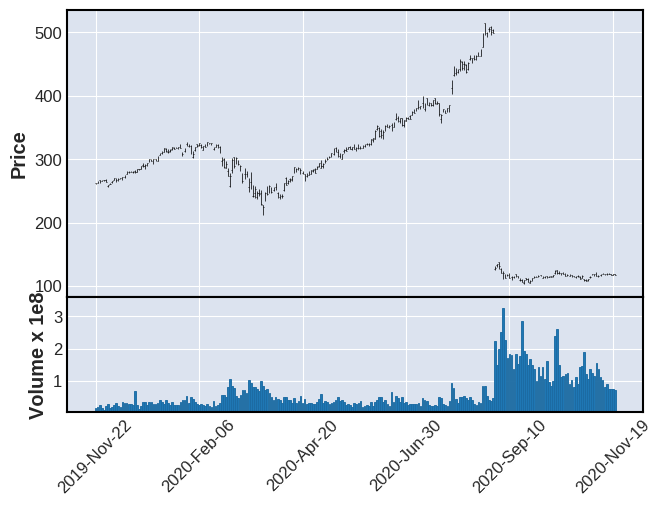

In [5]:
%matplotlib inline
import pandas as pd
import mplfinance as mpf

df = pd.DataFrame(result_data)
df["date"] = df["date"].astype("datetime64[ns]")
df.set_index("date", inplace=True)
df.sort_index(inplace=True)
mpf.plot(df, volume=True)

In [6]:
len(result_data)

252

# Connectors

Welcome to Capital!

#### What does Capital Do?

Capital uses data from third parties in order to help business owners better understand their business and finances.

The more data we have, the better decisions we can make.

Let's discuss how we do integrations here at Capital:

### How To Implement a Connector/Integration

Implementation of an integration *must* be done as follows:

 - data must be requested/returned one page at a time
 - handlers must respect rate limits and be runnable in a distributed environment
 - everything must be tested

Let's discuss the above via examples:

#### One Page At a Time

Before we get any further, there are a few terms we use here that you should be familiar with:

 - `Task` - a task is a request for a page of data-- it is always an object
 - `Handler` - a handler is a function that executes the `Task` and returns a `TaskResult`
 - `TaskResult` - an object that returns the page of data we retrieved in the `Handler` -- it is always an object

So here's the problem-- some of the data we download is huge-- many, many GBs! Too large to fit into memory.

Therefore, we can't do code like the following pseudocode:

```python

@dataclass
class Task:
    name:str = "api/data"
    credentials:str

@dataclass
class TaskResult:
    task:Task
    data:Any


# this is the wrong way of doing things
def handler(task:Task) -> TaskResult:
    api_data = []
    more_data = True

    while(more_data):
        page = 1
        this_data = api.get_data(page = page, credentials = task.credentials)
        api_data.append(this_data)
        if this_data["has_more"]:
            page += 1
        else:
            return TaskResult(task, api_data)

```

The above code tries to collect _all the data at once_, which would break once the data gets sufficiently large.

To get around this, we allow you to return the current page of data you just downloaded, AND a `Task` that represents that another page of data needs downloaded next:

```python

@dataclass
class Task:
    name:str = "api/data"
    credentials:str
    page:int = 1

@dataclass
class TaskResult:
    task:Task
    data:Any
    next_tasks: Iterable[Task]


# this is the correct way of doing things
def handler(task:Task) -> TaskResult:
    this_data = api.get_data(page = task.page, credentials = task.credentials)

    # if there's more data, return a new Task to get the next page of data
    if this_data["has_more"]:
        return TaskResult(task, this_data, [Task(dict(**task.__dict__ | {"page": task.page + 1}))])

    # if there is no more data, return an empty list of next_tasks
    return TaskResult(task, this_data, [])

```


#### Respect Rate Limits, Be Cool With Horizontal Scaling (Distsys)

We run these `Task` requests for data, and their `Handlers` in a distributed environment. We use redis and/or pylimit to solve this problem.

An example limitor that by default allows 9 requests every 1 second, and sleeps a little longer and longer until it gains access to call the api:

```python
from pylimit import PyRateLimit
import time

def limitor(namespace: str, fnn):
    lim = PyRateLimit(period=1, limit=9)
    sleep = [0.1, 0.4, 0.8, 1.3]
    attempts = 0

    while not lim.attempt(namespace):
        time.sleep(sleep.pop() if len(sleep) else 2)
        if attempts > 20:
            raise Exception(f"api limit exception {namespace}")

    return fnn()

#
# usage inside a handler looks like
this_data = limitor(task.name + task.credentials, lambda: api.get_data(page = task.page, credentials = task.credentials))

```

With redis-centralized locking via the code above, we're totally safe to run our code in a distributed environment.




--------



# A Test -- World Trading Data

Go to worldtradingdata.com and sign up for a free API key. 

Create a `Task` and `Handler` that download __all pages of data__ for all stocks that have "New York" in their name.

The base for this request URL is:

https://api.worldtradingdata.com/api/v1/stock_search?limit=50&page=1&api_token=[token]&search_term=new%20york

In [7]:
from dataclasses import dataclass
from typing import Any, Iterable


# put your code in here

@dataclass
class Task:
    credentials:str
    page:int = 1

@dataclass
class TaskResult:
    task:Task
    data:Any
    next_tasks: Iterable[Task]


